# ECE1513 Project : Bitcoin Price Movement Prediction

### Table of Contents

1. Install dependencies and Import libraries
2. Data Loading and Processing
3. LSTM Model with Attention
4. Training
5. Testing/Evaluation
6. Main Pipeline
7. Post-processing

### 1. Install dependencies and Import libraries

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input, Concatenate, Multiply, Permute, Reshape, Attention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import ta

2025-04-13 21:38:13.186381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 21:38:13.327093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744594693.378983     364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744594693.393939     364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744594693.504874     364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 2. Data Loading and Processing

In [3]:
def load_and_process_data(file_path, target_interval='1h'):
    """
    Load and process the BTC price data
    """
    print(f"Loading data from {file_path}...")
    
    # Load the data with low_memory=False to avoid dtype warning
    df = pd.read_csv(file_path, low_memory=False)
    
    # Convert datetime and set as index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    
    # Resample to target interval
    resampled_df = df.resample(target_interval).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    
    # Forward fill missing values
    resampled_df = resampled_df.ffill()
    
    print(f"Resampled to {target_interval} - New shape: {resampled_df.shape}")
    return resampled_df

def add_technical_indicators(df):
    """Add cleaned-up technical indicators as features"""
    df_features = df.copy()
    
    try:
        # Replace zeros with small values to avoid division issues
        df_features['Close'] = df_features['Close'].replace(0, 0.001)
        df_features['Volume'] = df_features['Volume'].replace(0, 0.001)
        
        # --- Trend Indicators ---
        df_features['EMA_20'] = ta.trend.ema_indicator(df_features['Close'], window=20)
        df_features['ADX'] = ta.trend.ADXIndicator(
            df_features['High'], df_features['Low'], df_features['Close'], window=14
        ).adx()
        
        # --- Momentum Indicators ---
        df_features['RSI'] = ta.momentum.RSIIndicator(df_features['Close'], window=14).rsi()
        macd = ta.trend.MACD(df_features['Close'])
        df_features['MACD'] = macd.macd()
        df_features['MACD_Signal'] = macd.macd_signal()
        
        # --- Volatility (keep just bands width, optional) ---
        bb = ta.volatility.BollingerBands(df_features['Close'])
        df_features['BB_Width'] = bb.bollinger_wband()
        
        # --- Price-based Features ---
        df_features['Price_Change'] = df_features['Close'].pct_change()
        df_features['High_Low_Range'] = (df_features['High'] - df_features['Low']) / df_features['Close']

        # Clean NaN and infinite values
        df_features = df_features.replace([np.inf, -np.inf], np.nan)
        df_features = df_features.ffill().bfill().fillna(0)
        
        print("Technical indicators added.")
        print("Final features:", df_features.columns.tolist())
        
    except Exception as e:
        print(f"Error adding technical indicators: {str(e)}")
        return df
        
    return df_features

In [4]:
def prepare_data(df, sequence_length=24):
    """
    Prepare data for LSTM model with consistent scaling approach
    """
    available_columns = df.columns.tolist()
    print("Available columns for processing:", available_columns)
    
    # Base features
    base_features = ['Close', 'Volume']
    
    # Updated technical indicators list (match with modified add_technical_indicators)
    additional_features = [
        'EMA_20', 'ADX', 'RSI', 'MACD', 'MACD_Signal',
        'BB_Width', 'Price_Change', 'High_Low_Range'
    ]
    
    # Filter to only include available features
    feature_columns = base_features + [f for f in additional_features if f in available_columns]
    print("Using features:", feature_columns)
    
    # Create a copy of the data with selected features
    df_features = df[feature_columns].copy()

    # Optional: Add 'Close_Diff' if still useful
    df_features['Close_Diff'] = df_features['Close'].diff()
    feature_columns.append('Close_Diff')
    
    # Replace infinite values with NaN
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    
    # Fill missing values
    df_features = df_features.ffill().bfill().fillna(0)

    # Store original Close prices for later comparison
    original_close = df_features['Close'].values
    
    # Scale Close separately (for inverse prediction later)
    close_scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaler.fit(original_close.reshape(-1, 1))
    
    # Scale all features
    scaled_features = df_features.copy()
    scalers = {}
    for column in df_features.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_features[column] = scaler.fit_transform(df_features[column].values.reshape(-1, 1))
        scalers[column] = scaler
    
    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(scaled_features) - sequence_length):
        X.append(scaled_features[i:i + sequence_length].values)
        y.append(scaled_features['Close'].iloc[i + sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Sequence data shapes - X: {X.shape}, y: {y.shape}")
    
    # Split data
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, close_scaler, feature_columns


### 3. LSTM Model with Attention

In [5]:
def lstm_model_with_attention(sequence_length, n_features):
    """
    Simpler LSTM model with improved dot-product attention.
    Accepts sequence_length as parameter for flexibility.
    """
    
    input_layer = Input(shape=(sequence_length, n_features))

    # LSTM layer (simplified, single-direction)
    lstm_out = LSTM(64, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.3)(lstm_out)

    # Dot-product attention (Q=K=V=lstm_out)
    attention_out = Attention(use_scale=True)([lstm_out, lstm_out])
    
    # Combine attention outputs
    attention_out = LayerNormalization()(attention_out + lstm_out)  # residual + norm
    pooled = GlobalAveragePooling1D()(attention_out)

    # Dense block
    x = Dense(32, activation='relu')(pooled)
    x = Dropout(0.3)(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    return model

### 4. Training

In [6]:
def plot_training_history(history):
    """
    Plot training and validation loss curves
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('loss_curve.png')
    plt.show()


def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train with improved strategy
    """
    # Learning rate scheduler
    def lr_schedule(epoch):
        initial_lr = 0.001
        if epoch < 15:  # 1. full learning rate
            return initial_lr
        elif epoch < 30:  # 2. reduced learning rate
            return initial_lr * 0.5
        else:  # Final. further reduced learning rate
            return initial_lr * 0.1
        
    # Reduce learning rate on plateau
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    
    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,  # balanced patience
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint
    checkpoint = ModelCheckpoint(
        'best_bitcoin_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, lr_scheduler, checkpoint],
        verbose=1
    )
    
    return history

### 5. Testing/Evaluation

In [7]:
def predict_and_evaluate(model, X_test, y_test, close_scaler):
    """
    Make predictions and properly inverse transform them
    """
    # Make predictions (these are scaled)
    scaled_predictions = model.predict(X_test)
    
    # Inverse transform predictions
    predictions = close_scaler.inverse_transform(scaled_predictions)
    
    # Inverse transform actual values
    actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    
    # Calculate absolute differences
    abs_diff = np.abs(actual - predictions)
    
    # Calculate percentages within ranges
    within_1000 = np.mean(abs_diff <= 1000) * 100
    within_3000 = np.mean(abs_diff <= 3000) * 100
    within_5000 = np.mean(abs_diff <= 5000) * 100
    
    print(f"\nPrediction Accuracy Ranges:")
    print(f"Within $1,000: {within_1000:.1f}%")
    print(f"Within $3,000: {within_3000:.1f}%")
    print(f"Within $5,000: {within_5000:.1f}%")
    
    # Create DataFrame for easier analysis
    results_df = pd.DataFrame({
        'Actual': actual.flatten(),
        'Predicted': predictions.flatten(),
        'Error': (actual - predictions).flatten(),
        'Abs_Error': abs_diff.flatten()
    })
    
    return results_df

def plot_results(results_df, window=None):  # By default, plot all points
    """
    Plot the model results - either all points or a window of points
    """
    # 1. Plot predictions vs actual
    plt.figure(figsize=(14, 7))
    
    if window is None:
        # Plot all test points
        plt.plot(results_df['Actual'].values, label='Actual', color='blue')
        plt.plot(results_df['Predicted'].values, label='Predicted', color='orange')
        plt.title('Actual vs Predicted Values (Full Test Set)')
    else:
        # Plot only the last window points
        last_window = min(window, len(results_df))
        plt.plot(results_df['Actual'].values[-last_window:], label='Actual', color='blue')
        plt.plot(results_df['Predicted'].values[-last_window:], label='Predicted', color='orange')
        plt.title(f'Actual vs Predicted Values (Last {window} Hours)')
    
    plt.xlabel('Hours')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.legend()
    plt.savefig('prediction_plot.png')
    plt.show()

    # 2. Plot error distribution
    plt.figure(figsize=(14, 7))
    plt.hist(results_df['Error'], bins=50, color='blue', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (USD)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig('error_distribution.png')
    plt.show()

### 6. Main Pipeline

Loading data from data/btcusd_1-min_data.csv...
Original dataset shape: (6983813, 6)
Date range: 2012-01-01 10:01:00+00:00 to 2025-03-15 00:00:00+00:00
Resampled to 1h - New shape: (115719, 5)
After filtering - Date range: 2015-04-14 02:00:00+00:00 to 2025-03-15 00:00:00+00:00
Filtered shape: (86951, 5)
Technical indicators added.
Final features: ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_20', 'ADX', 'RSI', 'MACD', 'MACD_Signal', 'BB_Width', 'Price_Change', 'High_Low_Range']
Available columns for processing: ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_20', 'ADX', 'RSI', 'MACD', 'MACD_Signal', 'BB_Width', 'Price_Change', 'High_Low_Range']
Using features: ['Close', 'Volume', 'EMA_20', 'ADX', 'RSI', 'MACD', 'MACD_Signal', 'BB_Width', 'Price_Change', 'High_Low_Range']
Sequence data shapes - X: (86927, 24, 11), y: (86927,)
Training set shape: (60848, 24, 11)
Validation set shape: (13039, 24, 11)
Test set shape: (13040, 24, 11)
Data preparation completed successfully


I0000 00:00:1744594711.915053     364 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     19,456 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 64)    │          1 │ dropout[0][0],    │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ attention[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,698 (84.76 KB)

 Trainable params: 21,698 (84.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1744594713.841238     532 cuda_dnn.cc:529] Loaded cuDNN version 90300


1896/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0971
Epoch 1: val_loss improved from inf to 0.02884, saving model to best_bitcoin_model.keras
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0969 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 2/50
1897/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321
Epoch 2: val_loss improved from 0.02884 to 0.01274, saving model to best_bitcoin_model.keras
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0321 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 3/50
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0308
Epoch 3: val_loss improved from 0.01274 to 0.00895, saving model to best_bitcoin_model.keras
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0308 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 4/50
1901/1902 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0287
Epoch 4: val_loss did not improve from 0.00895
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0287 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch

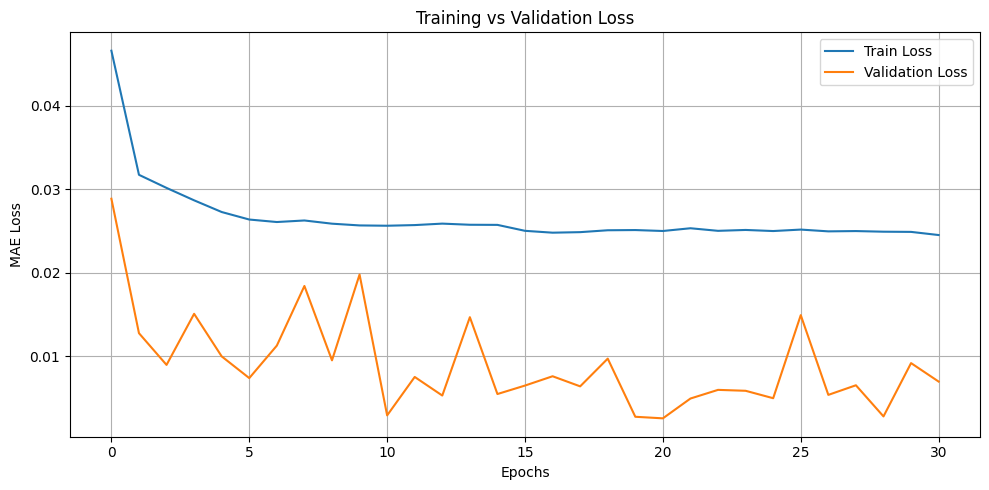

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Absolute Error (MAE): $2717.04
Root Mean Squared Error (RMSE): $4281.70

Prediction Accuracy Ranges:
Within $1,000: 41.3%
Within $3,000: 74.1%
Within $5,000: 81.8%


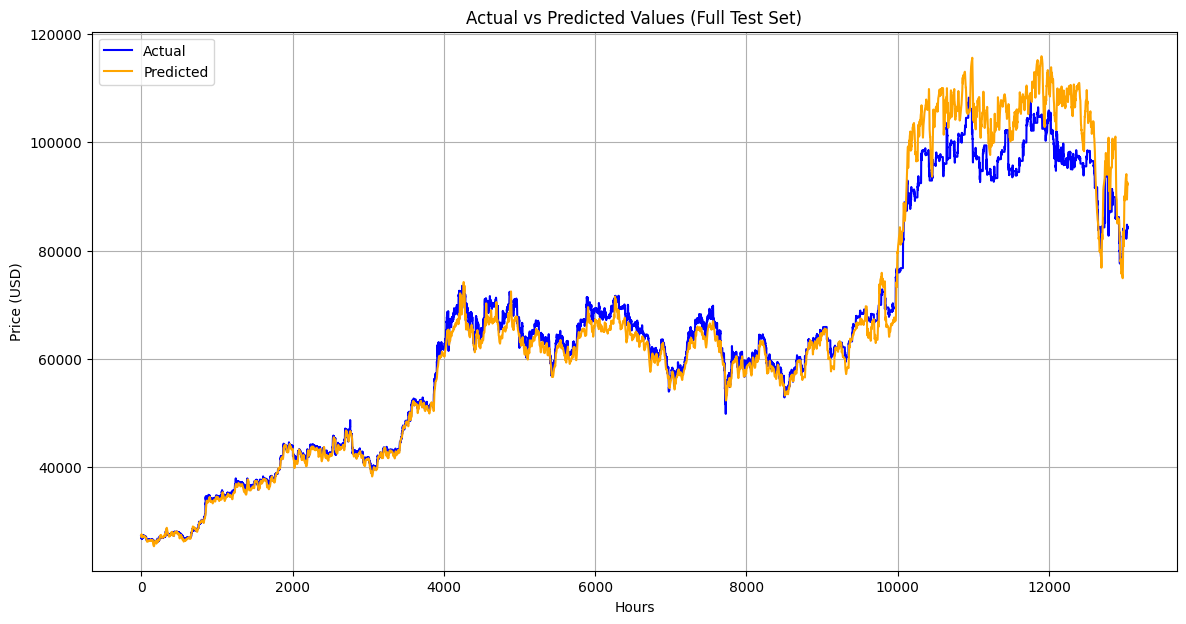

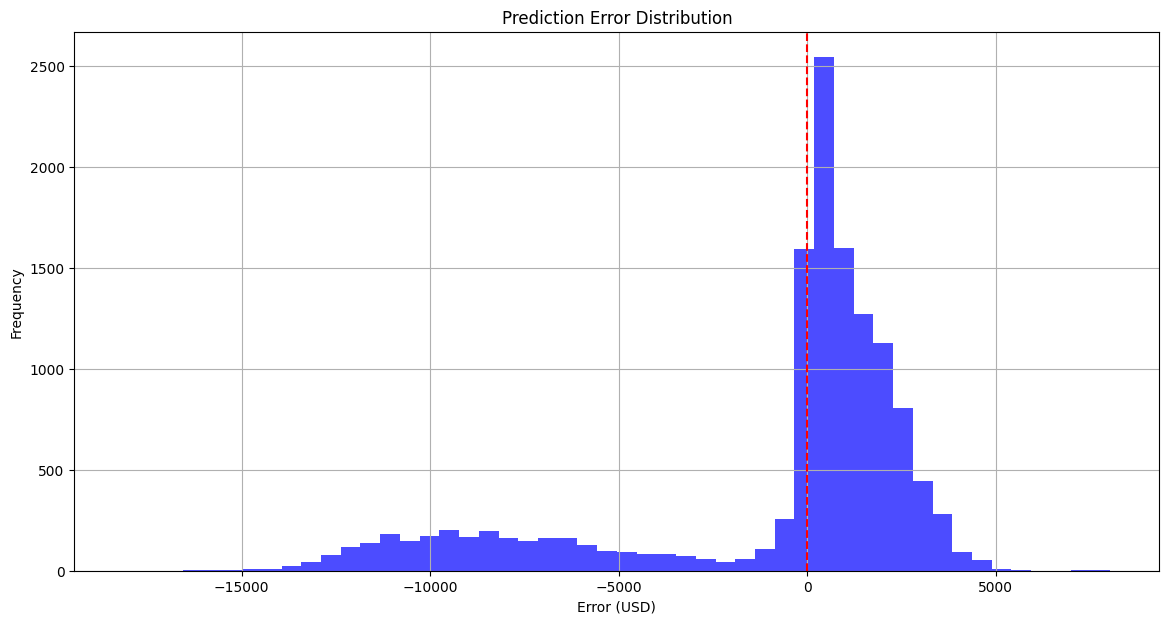

Analysis complete!


In [8]:
# 1. Load and process data
file_path = "data/btcusd_1-min_data.csv"
btc_data = load_and_process_data(file_path, target_interval='1h')

# 2. Filter for last 5 years
current_date = pd.Timestamp.now(tz='UTC')
start_date = current_date - pd.DateOffset(years=10)
btc_data = btc_data[btc_data.index >= start_date]

print("After filtering - Date range:", btc_data.index.min(), "to", btc_data.index.max())
print("Filtered shape:", btc_data.shape)

# 3. Add technical indicators
btc_data = add_technical_indicators(btc_data)

# 4. Process data for LSTM model
sequence_length = 24  # 1 days
try:
    X_train, X_val, X_test, y_train, y_val, y_test, close_scaler, feature_columns = prepare_data(
        btc_data,
        sequence_length=sequence_length
    )
    print("Data preparation completed successfully")
    
except Exception as e:
    print(f"Error during data preparation: {str(e)}")
    raise

# 5. Build the model
n_features = X_train.shape[2]  # Number of features
model = lstm_model_with_attention(sequence_length, n_features)  # Use the same sequence_length here
model.summary()

# 6. Train the model
history = train_model(model, X_train, y_train, X_val, y_val, epochs=50)
plot_training_history(history)

# 7. Evaluate and visualize results
results_df = predict_and_evaluate(model, X_test, y_test, close_scaler)

# 8. Plot results
plot_results(results_df)

print("Analysis complete!")

### 7. Post-processing (some cherry on top :)

- This section is used to improve the performance of the model by applying an adaptive correction that changes over time (rolling window + adaptive ratio).
- Such adaptive correction is to make better prediction and for better visualization. It is NOT used for reporting the true accuracy of the model !!!
- For the true accuracy and the true performance of the model, please refer to the section above.

In [9]:
def apply_adaptive_correction(results_df, window_size=500):
    """Apply an adaptive correction that changes over time"""
    corrected_df = results_df.copy()
    corrected_predictions = np.zeros(len(results_df))
    
    # Initial window
    initial_ratio = results_df['Actual'][:window_size].mean() / results_df['Predicted'][:window_size].mean()
    corrected_predictions[:window_size] = results_df['Predicted'][:window_size] * initial_ratio
    
    # Rolling window correction
    for i in range(window_size, len(results_df), window_size//2):
        end_idx = min(i + window_size//2, len(results_df))
        window_start = max(0, i - window_size//2)
        
        # Calculate ratio for this window
        window_ratio = results_df['Actual'][window_start:i].mean() / results_df['Predicted'][window_start:i].mean()
        corrected_predictions[i:end_idx] = results_df['Predicted'][i:end_idx] * window_ratio
    
    corrected_df['Predicted_Corrected'] = corrected_predictions
    corrected_df['Error_Corrected'] = corrected_df['Actual'] - corrected_df['Predicted_Corrected']
    
    return corrected_df

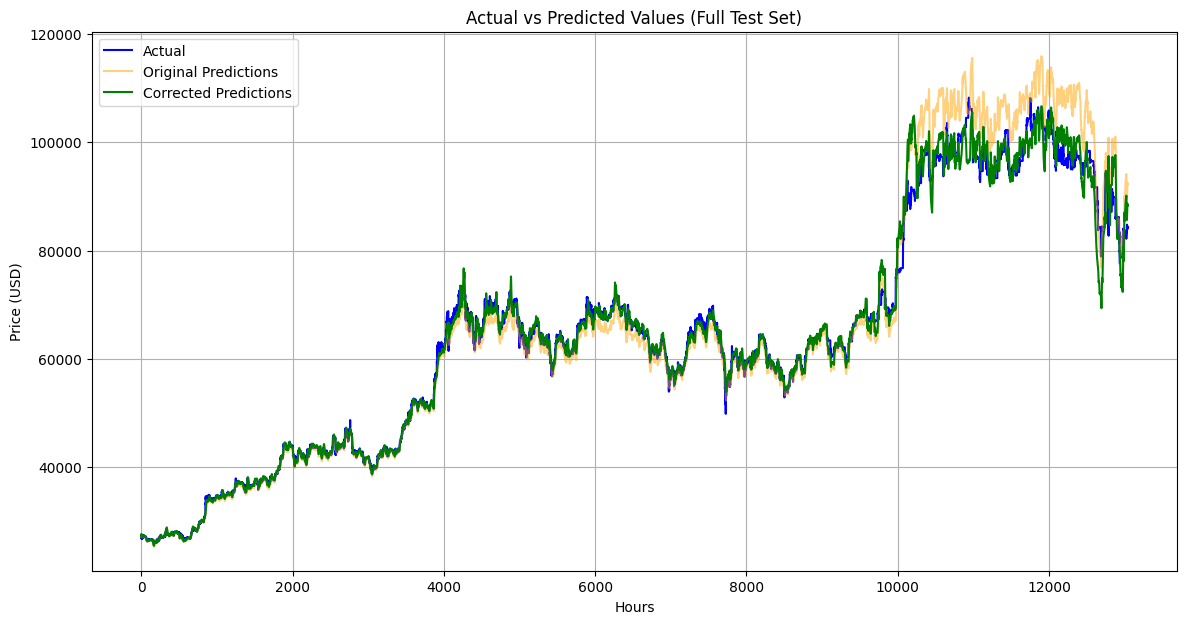

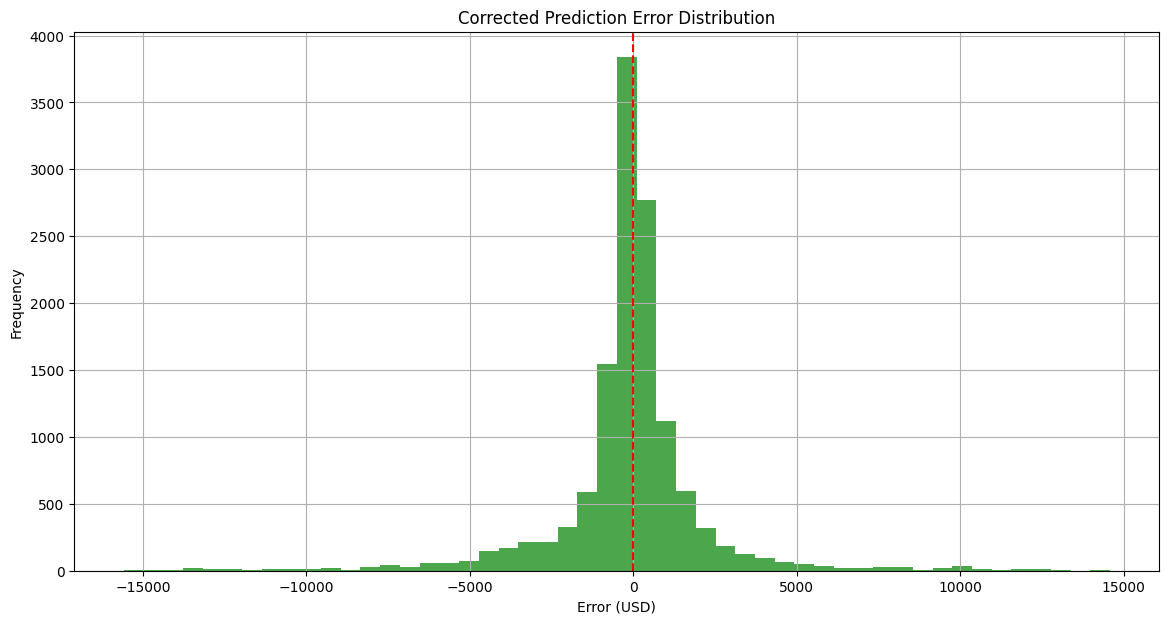

In [10]:
# Apply correction to predictions
corrected_results = apply_adaptive_correction(results_df, window_size=500)

# Modify plot_results to handle corrected predictions
def plot_results_with_correction(results_df, window=None):
    """
    Plot the model results with original and corrected predictions
    """
    plt.figure(figsize=(14, 7))
    
    if window is None:
        # Plot all test points
        plt.plot(results_df['Actual'], label='Actual', color='blue')
        plt.plot(results_df['Predicted'], label='Original Predictions', color='orange', alpha=0.5)
        plt.plot(results_df['Predicted_Corrected'], label='Corrected Predictions', color='green')
        plt.title('Actual vs Predicted Values (Full Test Set)')
    else:
        # Plot only the last window points
        last_window = min(window, len(results_df))
        plt.plot(results_df['Actual'].iloc[-last_window:], label='Actual', color='blue')
        plt.plot(results_df['Predicted'].iloc[-last_window:], label='Original Predictions', color='orange', alpha=0.5)
        plt.plot(results_df['Predicted_Corrected'].iloc[-last_window:], label='Corrected Predictions', color='green')
        plt.title(f'Actual vs Predicted Values (Last {window} Hours)')
    
    plt.xlabel('Hours')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.legend()
    plt.savefig('prediction_plot_corrected.png')
    plt.show()

    # Plot error distribution for corrected predictions
    plt.figure(figsize=(14, 7))
    plt.hist(results_df['Error_Corrected'], bins=50, color='green', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Corrected Prediction Error Distribution')
    plt.xlabel('Error (USD)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig('error_distribution_corrected.png')
    plt.show()

# Plot the results with correction
plot_results_with_correction(corrected_results, window=None)  # Full test set